# Import Library

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import imageio
import random
import matplotlib.pyplot as plt
import keras

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet50
from keras.layers import GlobalAveragePooling2D

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing for ResNet50

## Data Preprocessing

In [ ]:
data_dir = '/content/drive/MyDrive/Data/The IQ-OTHNCCD lung cancer dataset'
categories = ['begin', 'malignants', 'normal']

def preprocess_image(file_path):
    img = cv2.imread(file_path, 0)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # Convert to rgb image
    img = img / 255.0  # Normalize pixels in the range [0, 1]
    return img

data = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        img = preprocess_image(file_path)
        data.append(img)
        labels.append(label)

data, labels = shuffle(data, labels, random_state=42)


print('Data length:', len(data))
print('labels counts:', Counter(labels))

X = np.array(data).reshape(-1, 224, 224, 3)
y = np.array(labels)

Data length: 1097
labels counts: Counter({1: 561, 2: 416, 0: 120})


## Split Data

In [ ]:
X_fold, X_valid, y_fold, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)
# X,y valid are used for evaluate matrix

print('Train length:', len(X_fold), X_fold.shape)
print('Valid length:', len(X_valid), X_valid.shape)

Train length: 877 (877, 224, 224, 3)
Valid length: 220 (220, 224, 224, 3)


## Data Visualization

**NORMAL CASE**

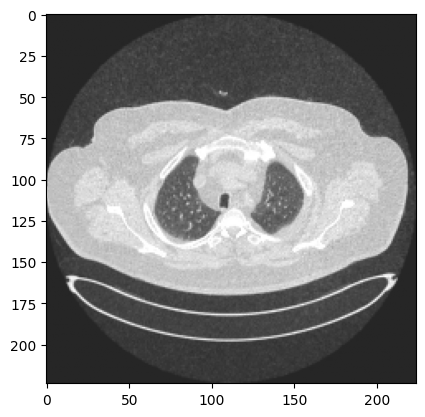

In [ ]:
plt.imshow(X[y==2][3])

**MAGLIGNANT CASE**

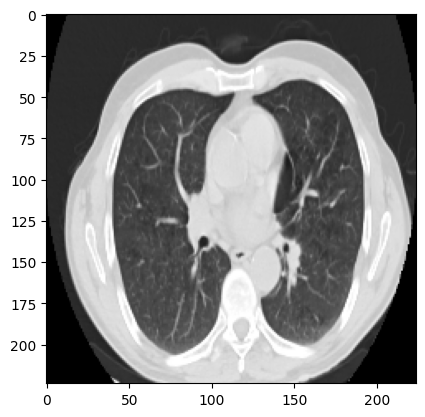

In [ ]:
plt.imshow(X[y==1][0])

**BENGIN CASE**

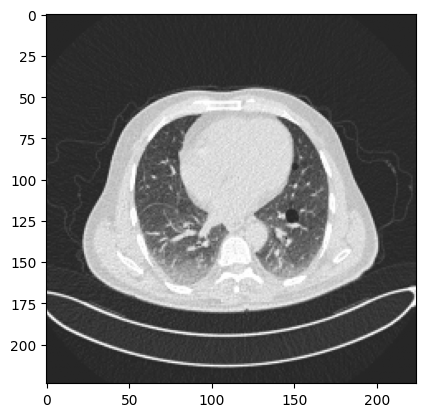

In [ ]:
plt.imshow(X[y==0][0])

# ResNet50

## Build model

In [ ]:
resnet_base = ResNet50(weights='imagenet', include_top=False,  input_shape=(224, 224, 3))

# Freeze the pre-trained layers so they are not updated during training
for layer in resnet_base.layers:
    layer.trainable = False

model_resnet = Sequential()


model_resnet.add(resnet_base)

model_resnet.add(Flatten())
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dense(3, activation='softmax'))

model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_10 (Flatten)        (None, 100352)            0         
                                                                 
 dense_26 (Dense)            (None, 128)               12845184  
                                                                 
 dense_27 (Dense)            (None, 3)                 387       
                                                                 
Total params: 36433283 (138.98 MB)
Trainable params: 12845571 (49.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


## Compile model

In [ ]:
model_resnet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Traning model

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=3)
history_resnet = keras.src.callbacks
model_accuracy = []
valid_accuracy = []
model_loss = []
valid_loss = []
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
for train_index, test_index in kf.split(X_fold):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_fold[train_index], X_fold[test_index]
    y_train, y_test = y_fold[train_index], y_fold[test_index]
    train_generator = train_datagen.flow(X_fold, y_fold, batch_size=16, shuffle=True)
    validation_generator = val_datagen.flow(X_test, y_test, batch_size=16, shuffle=True)
    # Initialize the model
    history_resnet = model_resnet.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[callback])
    model_accuracy.extend(history_resnet.history['accuracy'])
    valid_accuracy.extend(history_resnet.history['val_accuracy'])
    model_loss.extend(history_resnet.history['loss'])
    valid_loss.extend(history_resnet.history['val_loss'])


Epoch 1/50
103/103 [==============================] - 10s 60ms/step - loss: 2.2531 - accuracy: 0.5158 - val_loss: 0.8879 - val_accuracy: 0.5564
Epoch 2/50
103/103 [==============================] - 5s 52ms/step - loss: 0.8413 - accuracy: 0.6217 - val_loss: 0.8179 - val_accuracy: 0.6727
Epoch 3/50
103/103 [==============================] - 6s 54ms/step - loss: 0.7089 - accuracy: 0.6910 - val_loss: 0.7217 - val_accuracy: 0.6800
Epoch 4/50
103/103 [==============================] - 5s 49ms/step - loss: 0.7202 - accuracy: 0.6837 - val_loss: 0.6337 - val_accuracy: 0.6945
Epoch 5/50
103/103 [==============================] - 5s 51ms/step - loss: 0.5857 - accuracy: 0.7360 - val_loss: 0.5738 - val_accuracy: 0.7382
Epoch 6/50
103/103 [==============================] - 5s 49ms/step - loss: 0.5047 - accuracy: 0.7871 - val_loss: 0.6274 - val_accuracy: 0.6873
Epoch 7/50
103/103 [==============================] - 5s 53ms/step - loss: 0.4874 - accuracy: 0.7993 - val_loss: 0.4682 - val_accuracy: 0.792

## Model Evaluation

In [ ]:
y_pred2 = model_resnet.predict(X_valid, verbose=1)
y_pred_bool2 = np.argmax(y_pred2, axis=1)

print(classification_report(y_valid, y_pred_bool2))
print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool2))

9/9 [==============================] - 2s 89ms/step
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        35
           1       0.98      1.00      0.99       147
           2       1.00      0.99      0.99        93

    accuracy                           0.99       275
   macro avg       0.98      0.97      0.98       275
weighted avg       0.99      0.99      0.99       275

[[ 32   3   0]
 [  0 147   0]
 [  1   0  92]]


## Model visualization

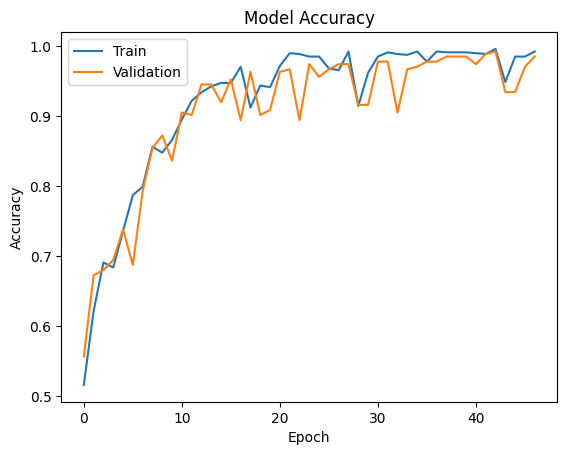

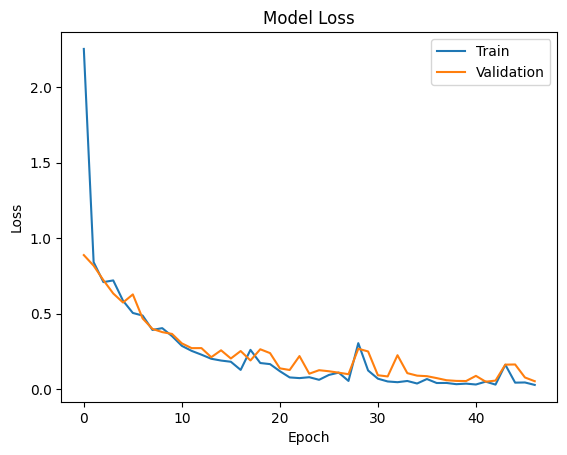

In [ ]:
plt.plot(model_accuracy, label='Train')
plt.plot(valid_accuracy, label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(model_loss, label='Train')
plt.plot(valid_loss, label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()